In [1]:
# import test_tensor_2d as tt ttbd
import quimb.tensor as qtn
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import spinlessQubit as sq
import hubbardAnalytical as han

In [19]:
reload(sq)
reload(han)

##Testing params
T_PARAM=1
V_PARAM=0
MU_PARAM=0
LX, LY = 2, 3


### Analytical Hubbard Hamiltonian
hub = han.FermiHubbardSpinless(Lx=LX, Ly=LY)
hub.build_spinless_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
gex, gsx = qu.eigh(hub._Ham)
# nx = hub.stateOccs(state=gsx[:,0])
# print(nx)


### Qubit lattice Hamiltonian
sql = sq.SpinlessQubitLattice(Lx=LX,Ly=LY)
sql.make_spinless_Hubbard(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
ge, gs = sql.eigspectrum()

# nv, nf = sql.stateLocalOccs(k=0)
# print(nv)
# plt.imshow(nv)
# plt.colorbar()
# print(nf)


3--->4,  face 6
4--->5,  face None
2--->1,  face None
1--->0,  face 6
3--->0,  face 6
5--->2,  face None
1--->4,  face 6


In [20]:
reload(sq)

sql.make_stabilizer()
# estates = sql._eigstates
H = sql._HamSim
proj = sql._stab_proj

projHam = proj@H
pevals, pevecs = qu.eigh(projHam)

# print(np.sort(pevals))



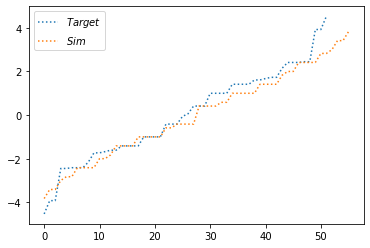

In [25]:
gex = np.around(gex,decimals=3)
plt.plot(gex[gex!=0.0], ':', label=r'$Target$')
pevals = np.around(pevals, decimals=3)
plt.plot(pevals[pevals!=0.0], ':',label=r'$Sim$')
plt.legend()


In [44]:
import qubitLattice as ql
from importlib import reload
reload(ql)

qq=ql.QubitLattice()
qq.build_spin_Hubbard()


MemoryError: Unable to allocate 4.00 GiB for an array with shape (16384, 16384) and data type complex128